<a href="https://colab.research.google.com/github/killer-cc/Breakthrough-the-wall-of-proxy-router/blob/main/DL_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!python -m pip install mxnet-cu100

     |████████████████████████████████| 352.6MB 50kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow import keras
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import plot_model
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras import layers, Sequential, optimizers
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Multiply, Conv2D, BatchNormalization, Flatten, Activation
from tensorflow.keras.layers import SeparableConv2D, Conv2DTranspose, Reshape, UpSampling2D, LeakyReLU, GaussianNoise, add, Lambda, Dot
import os
import cv2
import json
import time
import scipy
import zipfile
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from google.colab import drive
from google.colab import output


threshold = 96
batch_size = 64
codings_size = 144
n_epochs = 1000

從 kaggle 下載 animefacedataset

In [ ]:
#@title
#!pip install kaggle
api_token = {"username":"s36934512", "key":"c3c3e96a62503d2f5123e729d0ee0287"}

if not os.path.exists("/root/.kaggle"):
    os.makedirs("/root/.kaggle")

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json

if not os.path.exists("/kaggle"):
    os.makedirs("/kaggle")
os.chdir('/kaggle')
!kaggle datasets download -d splcher/animefacedataset --force
!unzip animefacedataset

從 google drive 下載 MixAnimeFaceDataset (新)

In [ ]:
drive.mount('/content/gdrive')
!unzip /content/gdrive/MyDrive/MixAnimeFaceDataset.zip
!unzip /content/gdrive/MyDrive/light-anime-face-detector.zip

In [ ]:
os.chdir('light-anime-face-detector-master')
from core.detector import LFFDDetector

os.environ["MXNET_CUDNN_AUTOTUNE_DEFAULT"] = "0"

with open('configs/anime.json', "r") as f:
  config = json.load(f)

detector = LFFDDetector(config, use_gpu=True)

Tue May 25 14:36:59 2021: Initializing.
Tue May 25 14:37:13 2021: Initialized (14.1182 seconds).


過濾小於 threshold 的圖

MixAnimeFaceDataset 內都大於 96 * 96


In [ ]:
#@title
#圖片尺寸
#min 25*25
#max 220*220

x = []
y = []
count = 0
image_paths = []
for img_path in Path('images').iterdir():
  img = cv2.imread( str(img_path) )
  w = img.shape[0]
  h = img.shape[1]
  x.append(w)
  y.append(h)
  count += 1

  if count % 1000 == 0:
    print(count)
  if w >= threshold and h >= threshold:
    image_paths.append( str(img_path) )

print(len(image_paths))
plt.plot(x, y)

建立 dataset 


In [ ]:
def load_and_preprocess_from_path(path):
  image = tf.io.read_file(path)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, [threshold, threshold])
  #image = tf.image.rgb_to_grayscale(image)
  #image = tf.image.grayscale_to_rgb(image)
  image /= 255.0
  return image

image_paths = [str(img_path) for img_path in Path('/content/MixAnimeFaceDataset').iterdir()]
print(len(image_paths))

dataset = tf.data.Dataset.from_tensor_slices(image_paths).map(load_and_preprocess_from_path).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1).cache()

500


In [ ]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

基礎GAN模型

In [ ]:
#@title
def make_discriminator_model(shape):
  img_input = keras.Input(shape=shape)
  flatten = layers.Flatten()(img_input)
  hidden1 = layers.Dense(150, activation="selu")(flatten)
  hidden2 = layers.Dense(100, activation="selu")(hidden1)
  output = layers.Dense(1, activation="sigmoid")(hidden2)

  model = keras.Model(inputs=img_input, outputs=output)

  return model

In [ ]:
#@title
def make_generator_model(shape):
  img_input = keras.Input(shape=shape)
  hidden1 = layers.Dense(100, activation="selu")(img_input)
  hidden2 = layers.Dense(150, activation="selu")(hidden1)
  hidden3 = layers.Dense(threshold * threshold * 3, activation="sigmoid")(hidden2)
  output = layers.Reshape([threshold, threshold, 3])(hidden3)

  model = keras.Model(inputs=img_input, outputs=output)

  return model

改進GAN模型

In [ ]:
def SE_Layer(shape):
    input = keras.Input(shape=shape)

    squeeze = GlobalAveragePooling2D()(input)
    excitation = Dense(shape[2]//16, activation='relu')(squeeze)
    excitation = Dense(shape[2], activation='sigmoid')(excitation)
    output = Multiply()([input, excitation])

    model = keras.Model(inputs=input, outputs=output)
    return model

In [ ]:
def ST_Layer(w_shape, c_shape, o_shape):
  w_input = keras.Input(shape=w_shape)
  c_input = keras.Input(shape=c_shape)

  AF = Dense(c_shape[2])(w_input)
  BC = Multiply()([c_input, AF])

  conv = Conv2D(o_shape, kernel_size=3, padding='same', activation=layers.LeakyReLU())(BC)
  output = BatchNormalization()(conv)

  model = keras.Model(inputs=[w_input, c_input], outputs=output)
  return model

In [ ]:
def ST2_Layer(w_shape, c_shape, o_shape):
  w_input = keras.Input(shape=w_shape)
  c_input = keras.Input(shape=c_shape)

  AF = Dense(c_shape[2])(w_input)
  BC = Multiply()([c_input, AF])

  upsamp = UpSampling2D(size=(2, 2))(BC)
  conv = Conv2D(o_shape, kernel_size=3, padding='same', activation=layers.LeakyReLU())(upsamp)
  output = BatchNormalization()(conv)

  model = keras.Model(inputs=[w_input, c_input], outputs=output)
  return model

In [ ]:
def make_discriminator_model(shape):
  real_input = keras.Input(shape=shape)
  fake_input = keras.Input(shape=shape)

  conv_r = Conv2D(32, kernel_size=3, padding='same')(real_input)
  conv_r = Conv2D(32, kernel_size=3, padding='same')(conv_r)
  conv_r = Conv2D(32, kernel_size=3, strides=2)(conv_r)
  BN_r = BatchNormalization()(conv_r)
  conv_r = Conv2D(32, kernel_size=3, padding='same')(BN_r)
  conv_r = Conv2D(32, kernel_size=3, padding='same')(conv_r)
  conv_r = Conv2D(32, kernel_size=3, strides=2)(conv_r)
  BN_r = BatchNormalization()(conv_r)

  conv_f = Conv2D(32, kernel_size=3, padding='same')(fake_input)
  conv_f = Conv2D(32, kernel_size=3, padding='same')(conv_f)
  conv_f = Conv2D(32, kernel_size=3, strides=2)(conv_f)
  BN_f = BatchNormalization()(conv_f)
  conv_f = Conv2D(32, kernel_size=3, padding='same')(BN_f)
  conv_f = Conv2D(32, kernel_size=3, padding='same')(conv_f)
  conv_f = Conv2D(32, kernel_size=3, strides=2)(conv_f)
  BN_f = BatchNormalization()(conv_f)

  add = keras.layers.add([BN_r, BN_f])
  conv4 = Conv2D(64, kernel_size=3, padding='same', activation=layers.LeakyReLU())(add)
  conv5 = Conv2D(64, kernel_size=3, padding='same', activation=layers.LeakyReLU())(conv4)
  conv6 = Conv2D(64, kernel_size=3, strides=2)(conv5)
  BN = BatchNormalization()(conv6)
  Sconv = SeparableConv2D(1, kernel_size=3, padding='same')(BN)
  GAP = GlobalAveragePooling2D()(Sconv)

  model = keras.Model(inputs=[real_input, fake_input], outputs=GAP)
  return model

In [ ]:
#@title
def make_generator_model(shape):
  input  = keras.Input(shape=shape)
  reshape = Reshape([12, 12, 1])(input)
  upsamp = UpSampling2D(size=(2, 2))(reshape)
  conv  = Conv2D(64, kernel_size=3, padding='same', activation=LeakyReLU())(upsamp)
  #seblock = SE_Layer((conv.shape[1], conv.shape[2], 64))(conv)
  #BN   = BatchNormalization()(seblock)
  BN   = BatchNormalization()(conv)
  upsamp = UpSampling2D(size=(2, 2))(BN)
  conv  = Conv2D(32, kernel_size=3, padding='same', activation=LeakyReLU())(upsamp)
  #seblock = SE_Layer((conv.shape[1], conv.shape[2], 32))(conv)
  #BN   = BatchNormalization()(seblock)
  BN   = BatchNormalization()(conv)
  upsamp = UpSampling2D(size=(2, 2))(BN)
  conv  = Conv2D(16, kernel_size=3, padding='same', activation=LeakyReLU())(upsamp)
  output = Conv2D(3, kernel_size=5, padding='same', activation='sigmoid')(conv)
  model = keras.Model(inputs=input, outputs=output)
  return model

In [ ]:
def make_generator_model(shape):
  latent_s = 92

  input  = keras.Input(shape=shape)

  FC = Dense(latent_s, activation=LeakyReLU())(input)
  FC = Dense(latent_s, activation=LeakyReLU())(FC)
  FC = Dense(latent_s, activation=LeakyReLU())(FC)
  FC = Dense(latent_s, activation=LeakyReLU())(FC)

  const = Dense(3 * 3 * latent_s)(input)
  const = GaussianNoise(1)(const)
  const = Reshape([3, 3, latent_s])(const)
  ST = ST_Layer(latent_s, [3, 3, latent_s], latent_s)([FC, const])
  conv3 = GaussianNoise(1)(ST)
  ST2 = ST2_Layer(latent_s, [3, 3, latent_s], latent_s)([FC, conv3])

  conv6 = GaussianNoise(1)(ST2)
  conv6up = UpSampling2D(size=(2, 2))(ST2)
  ST_2 = ST_Layer(latent_s, [6, 6, latent_s], latent_s)([FC, conv6])
  conv66 = GaussianNoise(1)(ST_2)
  ST2_2 = ST2_Layer(latent_s, [6, 6, latent_s], latent_s)([FC, conv6])

  conv12 = GaussianNoise(1)(ST2_2)
  ST_3 = ST_Layer(latent_s, [12, 12, latent_s], latent_s)([FC, conv12])
  conv12 = GaussianNoise(1)(ST_3)
  conv12 = add([conv12, conv6up])
  ST2_3 = ST2_Layer(latent_s, [12, 12, latent_s], latent_s)([FC, conv12])

  conv24 = GaussianNoise(1)(ST2_3)
  conv24up = UpSampling2D(size=(2, 2))(ST2_3)
  ST_4 = ST_Layer(latent_s, [24, 24, latent_s], latent_s)([FC, conv24])
  conv24 = GaussianNoise(1)(ST_4)
  ST2_4 = ST2_Layer(latent_s, [24, 24, latent_s], latent_s)([FC, conv24])

  conv48 = GaussianNoise(1)(ST2_4)
  ST_5 = ST_Layer(latent_s, [48, 48, latent_s], latent_s)([FC, conv48])
  conv48 = GaussianNoise(1)(ST_5)
  conv48 = add([conv48, conv24up])
  ST2_5 = ST2_Layer(latent_s, [48, 48, latent_s], latent_s)([FC, conv48])

  output = Conv2D(3, kernel_size=3, padding='same', activation='sigmoid')(ST2_5)
  #output = Lambda(lambda x: (x * 255) // 255)(Poutput)
  model = keras.Model(inputs=input, outputs=output)

  return model

loss function = Frechet Inception Distance


Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 144)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 92)           13340       input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 92)           8556        dense[0][0]                      
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 828)          120060      input_1[0][0]                    
___________________________________________________________________________________________

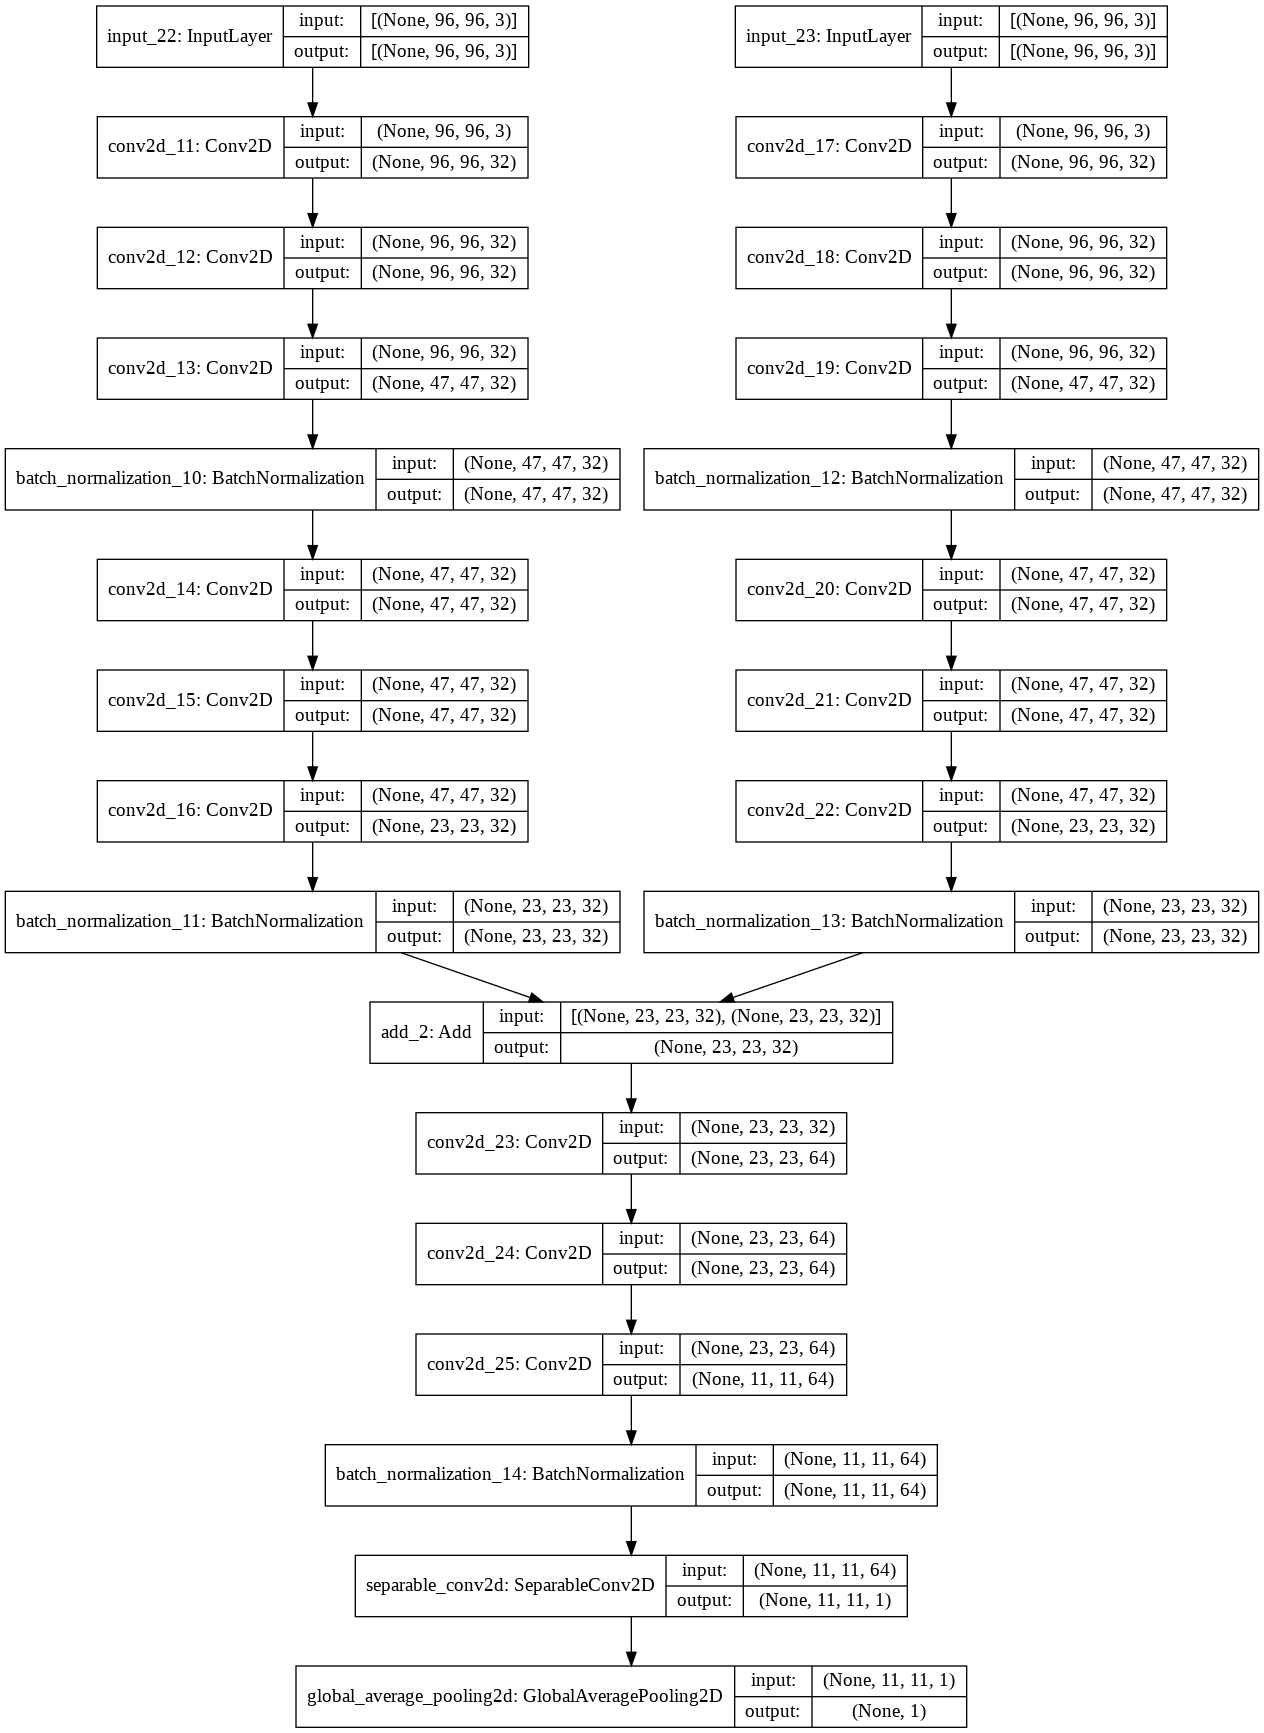

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

generator = make_generator_model((codings_size))
discriminator = make_discriminator_model((threshold, threshold, 3))

gen_optimizer = tf.keras.optimizers.Adam(0.05)
disc_optimizer = tf.keras.optimizers.Adam(0.0004)

generator.summary()
discriminator.summary()
inception = InceptionV3(include_top=False, pooling='avg', input_shape=[threshold, threshold, 3])

plot_model(generator, to_file='generator_model_plot.png', show_shapes=True, show_layer_names=True)
plot_model(discriminator, to_file='discriminator_model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
def calculate_fid(model, images1, images2):
  f1, f2 = [model(preprocess_input(im)).numpy() for im in (images1, images2)]
  mean1, sigma1 = f1.mean(axis=0), np.cov(f1, rowvar=False)
  mean2, sigma2 = f2.mean(axis=0), np.cov(f2, rowvar=False)
  sum_sq_diff = np.sum((mean1 - mean2)**2)
  cov_mean = scipy.linalg.sqrtm(sigma1.dot(sigma2))
  if np.iscomplexobj(cov_mean):
    cov_mean = cov_mean.real
  fid = sum_sq_diff + np.trace(sigma1 + sigma2 - 2.0*cov_mean)
  return fid

In [ ]:
def generator_loss(fake_image, real_image, Discriminator_diff_out, k=0.01):
  fid = calculate_fid(inception, real_image, fake_image)

  loss_detector = 0
  num_confidence = 1

  for image in fake_image:
    image = image.numpy()#.astype('float32')
    for box in detector.detect(image):
      loss_detector += box['confidence']
      num_confidence += 1

  loss = tf.exp( tf.reduce_mean(Discriminator_diff_out) + (1 - loss_detector/num_confidence) ) + k * fid
  return loss

In [ ]:
def discriminator_loss(Discriminator_diff_out, Discriminator_same_out):
  loss = tf.reduce_mean(Discriminator_same_out) - tf.reduce_mean(Discriminator_diff_out)
  return loss

In [ ]:
#@tf.function
def train_discriminator(images):
    noise = tf.random.normal([batch_size, codings_size])

    with tf.GradientTape() as disc_tape:
        generated_imgs = generator(noise)

        diff_output = discriminator([images, generated_imgs], training=True)
        same_output = discriminator([images, images], training=True)

        disc_loss = discriminator_loss(diff_output, same_output)

    grad_disc = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    print("grad_disc:", tf.reduce_mean(grad_disc[0]))
    print("grad_disc:", tf.reduce_mean(grad_disc[-1]))
    disc_optimizer.apply_gradients(zip(grad_disc, discriminator.trainable_variables))

    for param in discriminator.trainable_variables:
        # Except gamma and beta in Batch Normalization
        if param.name.split('/')[-1].find('gamma') == -1 and param.name.split('/')[-1].find('beta') == -1:
            param.assign(tf.clip_by_value(param, -0.01, 0.01))

    return disc_loss

#@tf.function
def train_generator(images):
  noise = tf.random.normal([batch_size, codings_size])

  with tf.GradientTape() as gen_tape:
    generated_imgs = generator(noise, training=True)
    diff_output = discriminator([images, generated_imgs], training=False)

    gen_loss = generator_loss(generated_imgs, images, diff_output)

  grad_gen = gen_tape.gradient(gen_loss, generator.trainable_variables)
  #print(grad_gen)
  print("grad_gen:", tf.reduce_mean(grad_gen[0]))
  print("grad_gen:", tf.reduce_mean(grad_gen[-1]))
  gen_optimizer.apply_gradients(zip(grad_gen, generator.trainable_variables))

  return gen_loss

reload weights

In [ ]:
#@title
generator.load_weights('/content/gdrive/MyDrive/girl_generator.h5')
discriminator.load_weights('/content/gdrive/MyDrive/girl_discriminator.h5')

設置訓練

In [ ]:
def train_gan(dataset, batch_size, codings_size, n_epochs, n_critic=1):
  for epoch in range(n_epochs):
    if epoch % 10 == 0:
      generator.save('/content/gdrive/MyDrive/girl_generator.h5')
      discriminator.save('/content/gdrive/MyDrive/girl_discriminator.h5')
      output.clear()
      for Real_image in dataset:
        plot_multiple_images(Real_image[:20], 20)
        break

    print("Epoch {}/{}".format(epoch + 1, n_epochs))
    start_time = time.time()

    disc_loss = 0
    gen_loss = 0
    for Real_image in dataset:
      disc_loss += train_discriminator(Real_image)

      if disc_optimizer.iterations.numpy() % n_critic == 0:
        gen_loss += train_generator(Real_image)
    print('Time for epoch {} is {} sec - gen_loss = {}, disc_loss = {}'.format(epoch+1, int(time.time()-start_time), gen_loss/batch_size, disc_loss / (batch_size*n_critic)))
    
    noise = tf.random.normal(shape=[batch_size, codings_size])
    generated_images = generator(noise).numpy()

    plot_multiple_images(generated_images[:20], 20) # not shown
    plt.show()

Epoch 91/1000
Epoch 91/1000
grad_disc: grad_disc: tf.Tensor(1.2389594e-09, shape=(), dtype=float32)
grad_disc: tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(1.2389594e-09, shape=(), dtype=float32)
grad_disc: tf.Tensor(0.0, shape=(), dtype=float32)
grad_gen: grad_gen: tf.Tensor(3.7616516e-12, shape=(), dtype=float32)
grad_gen: tf.Tensor(-1.02629634e-10, shape=(), dtype=float32)
tf.Tensor(3.7616516e-12, shape=(), dtype=float32)
grad_gen: tf.Tensor(-1.02629634e-10, shape=(), dtype=float32)
grad_disc: grad_disc: tf.Tensor(7.4422735e-10, shape=(), dtype=float32)
grad_disc: tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(7.4422735e-10, shape=(), dtype=float32)
grad_disc: tf.Tensor(0.0, shape=(), dtype=float32)
grad_gen: grad_gen: tf.Tensor(4.3169407e-13, shape=(), dtype=float32)
grad_gen: tf.Tensor(-1.7551605e-10, shape=(), dtype=float32)
tf.Tensor(4.3169407e-13, shape=(), dtype=float32)
grad_gen: tf.Tensor(-1.7551605e-10, shape=(), dtype=float32)
grad_disc: grad_disc: tf.Tensor(1.7165

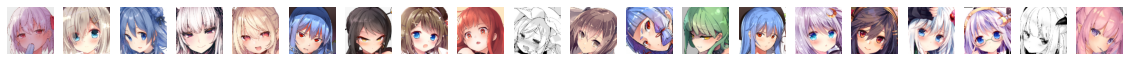

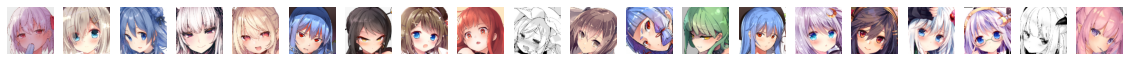

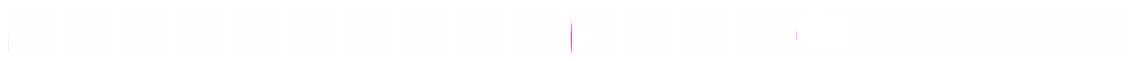

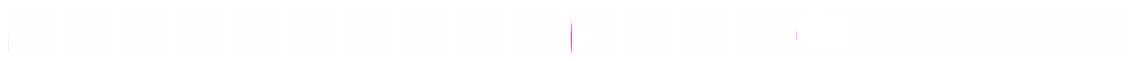

Epoch 92/1000
Epoch 92/1000
grad_disc: grad_disc: tf.Tensor(1.1356006e-09, shape=(), dtype=float32)
grad_disc: tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(1.1356006e-09, shape=(), dtype=float32)
grad_disc: tf.Tensor(0.0, shape=(), dtype=float32)
grad_gen: grad_gen: tf.Tensor(2.294415e-13, shape=(), dtype=float32)
grad_gen: tf.Tensor(-1.6731998e-10, shape=(), dtype=float32)
tf.Tensor(2.294415e-13, shape=(), dtype=float32)
grad_gen: tf.Tensor(-1.6731998e-10, shape=(), dtype=float32)
grad_disc: grad_disc: tf.Tensor(4.696373e-10, shape=(), dtype=float32)
grad_disc: tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(4.696373e-10, shape=(), dtype=float32)
grad_disc: tf.Tensor(0.0, shape=(), dtype=float32)
grad_gen: grad_gen: tf.Tensor(-4.0920473e-13, shape=(), dtype=float32)
grad_gen: tf.Tensor(-1.3803239e-10, shape=(), dtype=float32)
tf.Tensor(-4.0920473e-13, shape=(), dtype=float32)
grad_gen: tf.Tensor(-1.3803239e-10, shape=(), dtype=float32)
grad_disc: grad_disc: tf.Tensor(1.9219955e

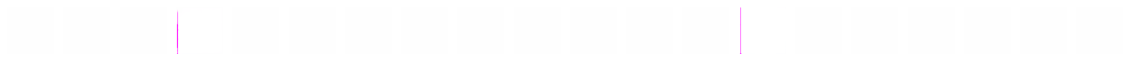

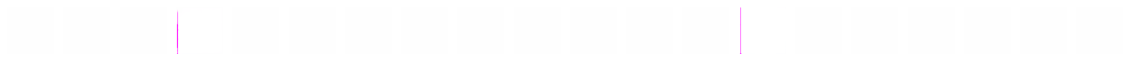

Epoch 93/1000
Epoch 93/1000
grad_disc: grad_disc: tf.Tensor(1.2193384e-09, shape=(), dtype=float32)
grad_disc: tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(1.2193384e-09, shape=(), dtype=float32)
grad_disc: tf.Tensor(0.0, shape=(), dtype=float32)
grad_gen: grad_gen: tf.Tensor(1.8511523e-12, shape=(), dtype=float32)
grad_gen: tf.Tensor(-1.6179913e-10, shape=(), dtype=float32)
tf.Tensor(1.8511523e-12, shape=(), dtype=float32)
grad_gen: tf.Tensor(-1.6179913e-10, shape=(), dtype=float32)
grad_disc: grad_disc: tf.Tensor(3.3208547e-10, shape=(), dtype=float32)
grad_disc: tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(3.3208547e-10, shape=(), dtype=float32)
grad_disc: tf.Tensor(0.0, shape=(), dtype=float32)
grad_gen: grad_gen: tf.Tensor(2.9756499e-12, shape=(), dtype=float32)
grad_gen: tf.Tensor(-1.3004738e-10, shape=(), dtype=float32)
tf.Tensor(2.9756499e-12, shape=(), dtype=float32)
grad_gen: tf.Tensor(-1.3004738e-10, shape=(), dtype=float32)
grad_disc: grad_disc: tf.Tensor(2.107685

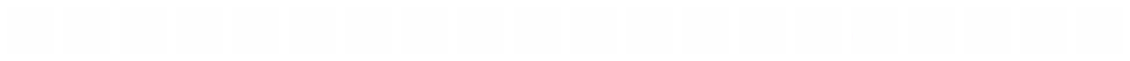

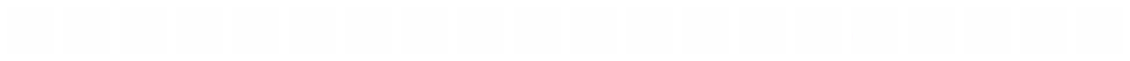

Epoch 94/1000
Epoch 94/1000
grad_disc: grad_disc: tf.Tensor(2.0397832e-09, shape=(), dtype=float32)
grad_disc: tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(2.0397832e-09, shape=(), dtype=float32)
grad_disc: tf.Tensor(0.0, shape=(), dtype=float32)
grad_gen: grad_gen: tf.Tensor(1.2479054e-12, shape=(), dtype=float32)
grad_gen: tf.Tensor(-2.0907516e-10, shape=(), dtype=float32)
tf.Tensor(1.2479054e-12, shape=(), dtype=float32)
grad_gen: tf.Tensor(-2.0907516e-10, shape=(), dtype=float32)
grad_disc: grad_disc: tf.Tensor(1.000637e-09, shape=(), dtype=float32)
grad_disc: tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(1.000637e-09, shape=(), dtype=float32)
grad_disc: tf.Tensor(0.0, shape=(), dtype=float32)
grad_gen: grad_gen: tf.Tensor(6.1526777e-13, shape=(), dtype=float32)
grad_gen: tf.Tensor(-2.5712485e-10, shape=(), dtype=float32)
tf.Tensor(6.1526777e-13, shape=(), dtype=float32)
grad_gen: tf.Tensor(-2.5712485e-10, shape=(), dtype=float32)
grad_disc: grad_disc: tf.Tensor(2.4356257e

In [ ]:
train_gan(dataset, batch_size, codings_size, n_epochs)

In [ ]:
image = cv2.imread('/content/MixAnimeFaceDataset/1003_2000.jpg')
print(image.shape)

boxes = detector.detect(image)
print(boxes)

(116, 116, 3)
[{'xmin': 0, 'ymin': 5, 'xmax': 116, 'ymax': 116, 'confidence': 0.9527996}]
